# eq_IO_SST_sea_cycle: Zonal structure of the amplitude of the mean seasonal cycle of SST in the equatorial Indian Ocean

Computes the zonal root mean square error (RMSE) of equatorial Indian Ocean (50°E-110°E) amplitude (standard deviation) of the mean annual cycle (zonal 10°S-10°N average) sea surface temperature (SST) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

## Observations and reanalysis datasets used for comparison

The following reference observational datasets are used to evaluate the model simulations:

- **HadISST (1870-2018)**: The Hadley Centre Sea Ice and Sea Surface Temperature dataset offers global monthly SST and sea ice concentration fields, incorporating in-situ and satellite data for climate variability analysis.

## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36535 instead
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysi

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36535/status,
Dashboard: /proxy/36535/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46867,Workers: 0
Dashboard: /proxy/36535/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33149,Total threads: 1
Dashboard: /proxy/38511/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44577,


## Datasets

In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
),
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
# "ACCESS-ESM1-5": 
#     Dataset(
#     short_name='tos',
#     project='CMIP6',
#     mip="Omon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-ESM1-5",
#     grid="gn"
# )
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
}

## Add Ancillary files

In [4]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [5]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/esmvalcore/config/_config.py:59: ESMValCoreDeprecationWarning: Usage of extra facets located in ~/.esmvaltool/extra_facets has been deprecated in ESMValCore version 2.13.0 and is scheduled for removal in version 2.15.0. Please use the configuration option `extra_facets` instead (see https://github.com/ESMValGroup/ESMValCore/pull/2747 for details). To silent this warning and ignore deprecated extra facets, set the environment variable ESMVALTOOL_USE_NEW_EXTRA_FACETS_CONFIG=1.
  warn_if_old_extra_facets_exist()
(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/esmvalcore/config/_config.py:59: ESMValCoreDeprecationWarning: Usage of extra facets located in ~/.esmvaltool/extra_facets has been deprecated in ESMValCore

In [6]:
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [7]:
def prepoc1(cube):
    equatorial_indian_region = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = climate_statistics(cube, operator='mean', period='monthly')
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed(['month_number'], iris.analysis.STD_DEV)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **equatorial_indian_region)    
    cube = axis_statistics(cube, operator="mean", axis="y")
    return cube

def prepoc2(cube):
    equatorial_indian_latext_region = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -25., "end_latitude": 25.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator='mean', period='monthly')
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed(['month_number'], iris.analysis.STD_DEV)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **equatorial_indian_latext_region)
    return cube

In [8]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

# Diagnostics Level 1


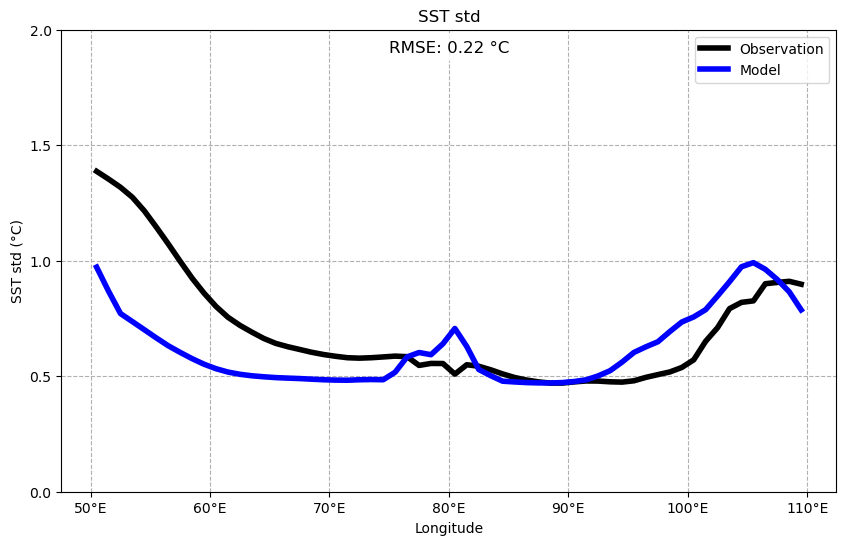

In [9]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["HadISST"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('SST std (°C)')
plt.title('SST std')
plt.grid(linestyle='--')
plt.yticks(np.arange(0,2.5, step=0.5))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} °C', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Figure 1: Zonal bias in the amplitude of the mean seasonal cycle of sea surface temperature (SST) in the equatorial Indian Ocean (averaged between 10°S–10°N). The black curve represents the reference data, while the blue curve represents the model data. The metric displayed is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


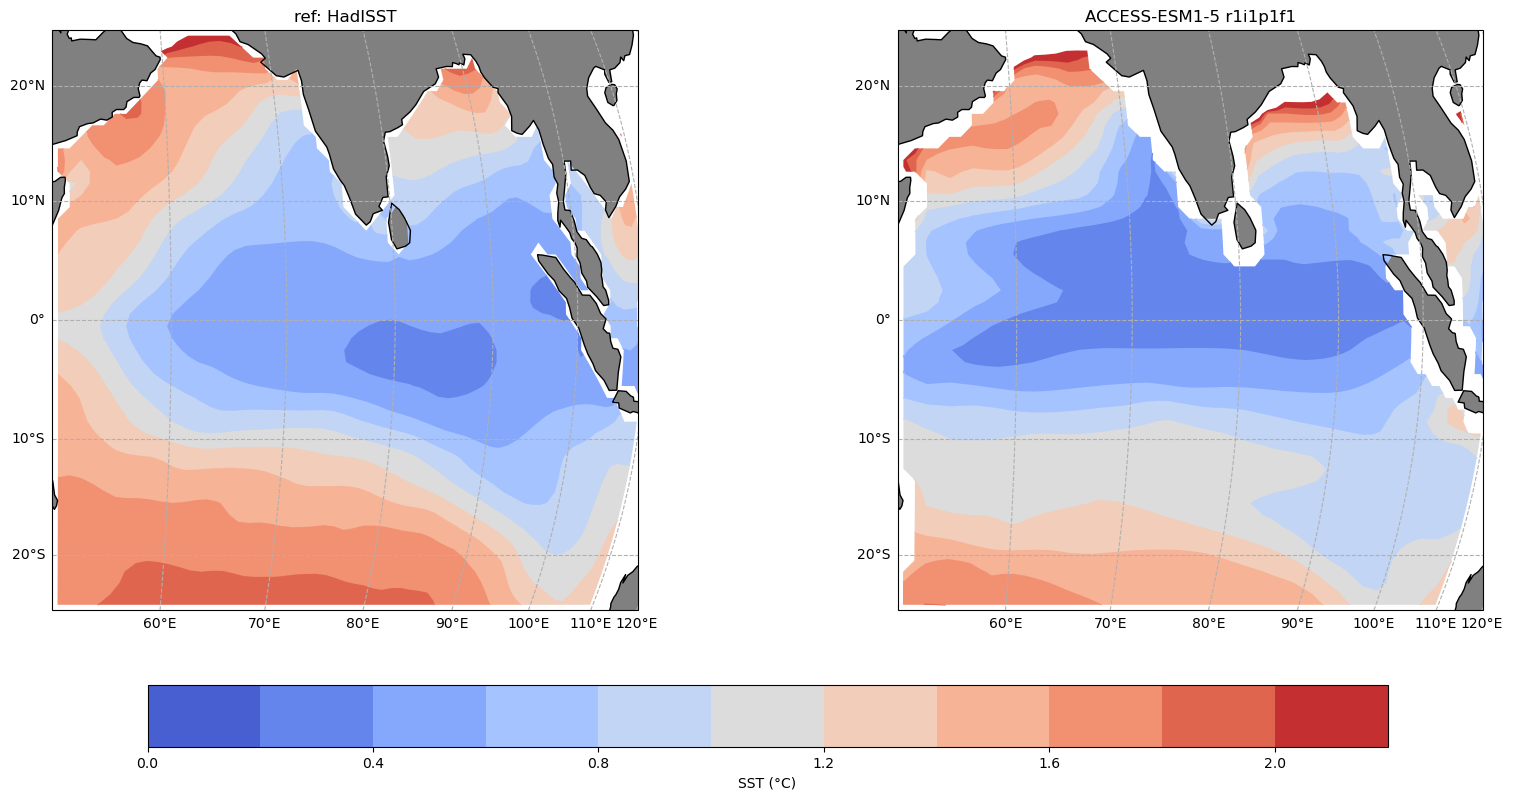

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep2["HadISST"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('coolwarm')

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=50, central_latitude=0)
# Define the normalization for the color scale with range of 20 to 33°C
norm = mcolors.Normalize()

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm,levels=np.arange(0,2.4,0.2))
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([50, 110, -25, 25], crs=ccrs.PlateCarree())
ax1.set_title("ref: HadISST")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm,levels=np.arange(0,2.4,0.2))
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([50, 110, -25, 25], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('SST (°C)')
#cbar.set_ticks(np.arange(20, 33))  # Set ticks at intervals of 2 degrees

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


Figure 2: Bias in the amplitude of the mean seasonal cycle of sea surface temperature (SST) in the equatorial Indian Ocean. The left map represents the reference data, while the right map shows the model data.

# Diagnostic Level 3

The third level shows the zonal structure of the mean seasonal cycle in the western Indian Ocean in a Hovmöller diagram

In [11]:
from esmvalcore.preprocessor import axis_statistics


def preproc3(cube):
    eq_region = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **eq_region)
    cube = axis_statistics(cube, axis="y", operator='mean')
    return cube

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}
process = {**obs_datasets_prep3, **model_datasets_prep3}

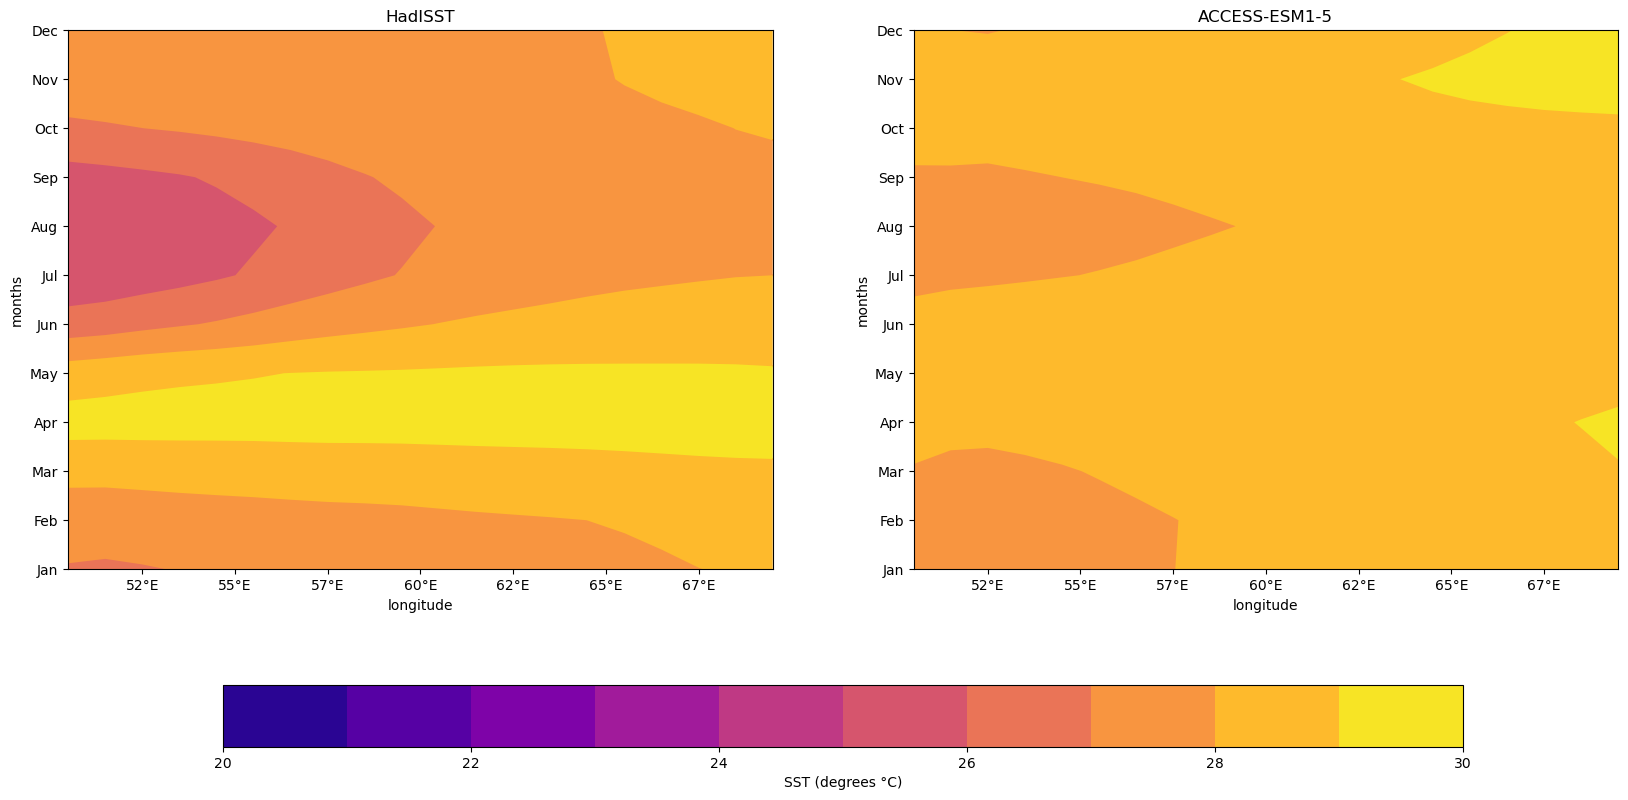

In [12]:
fig = plt.figure(figsize=(20, 10))
i=121

# Define tick positions and labels for the y-axis (months)
month_ticks = np.arange(1, 13, 1)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axls =[]
for label, cube in process.items():
    
    ax1 = plt.subplot(i)
    cf1 = iplt.contourf(cube,coords=['longitude','month_number'],levels=np.arange(20,31,1),cmap="plasma")
    ax1.set_ylim(1, 12)
    ax1.set_yticks(ticks=month_ticks, labels=month_labels)
    ax1.set_title(label)
    ax1.set_ylabel("months")
    ax1.set_xlabel("longitude")
    axls.append(ax1)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
    i+=1

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf1, ax=axls, orientation='horizontal',shrink=0.8, extend='both')
cbar.set_label('SST (degrees °C)')

Figure 3: zonal structure of the mean seasonal cycle of sea surface temperature (SST) in the western equatorial Indian Ocean (10°S-10°N averaged). The left and right maps show respectively the reference and the model